# CNN: visualization and interpretation

#### General instructions

You have roughly **2 WEEKS** to complete and submit each of the remaining assigments. There are 3 weekly group sessions available to help you complete the assignments. Attendance is not mandatory but recommended. However, assignments are graded each week and not submitting them or submitting them after the deadline will give you no points

**FORMAT**: Jupyter notebook  
**DEADLINE**: Sunday 21st March, 23:59

## Introduction

Deep learning models are often criticized for being a black box. To assert this problem many visualization techniques have been developped in order to get a better understanding of how the model is learning and how to interpret its results. In this assignment we will go through some of these techniques, based on this week's module's video *[Lecture 12 | Visualizing and Understanding](https://www.youtube.com/watch?v=6wcs6szJWMY&list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv&index=15)* 


## Contents:

1. Preliminary  
  1.1 Back to pre-trained networks   
  1.2 Accessing layers and weights of the ResNet model  
2. First convolutional layer  
3. Last layer: Nearest neighbors  
  3.1 Comparing images pixel wise  
  3.2 Comparing images in the feature space of the last layer of resnet   
4. Last layer: Dimensionality reduction and distinguishing between kitchens and trains  
5. Hidden convolutional layers: Maximum activations  
6. Occlusion experiments  




In [1]:
import torch
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
from matplotlib import pyplot as plt
from os import listdir
from math import ceil, sqrt
from sklearn.metrics import pairwise_distances
import numpy as np
from random import randint
from sklearn.decomposition import PCA
import torch.nn.functional as F
import seaborn  as sns
import torch.nn as nn

## 1. Preliminary

### 1.1 Back to pre-trained networks

In this assignment we will use the very same model we used in the first assignment of this course: [ResNet101](https://pytorch.org/vision/stable/models.html#torchvision.models.resnet101). This network is a deep neural network that has been trained with the [ImageNet](http://image-net.org/) dataset. In this assignmnent though, we will use a different dataset, a subset of the [COCO](https://cocodataset.org/#download) dataset and we will see that ResNet can still do amazing things with this dataset! 

--------------------
## TODO

Take a deep breath and enjoy how more familiar this output looks compared to when you first met it 6 weeks ago. :) Now Conv2d has no secret for you, nor has BatchNorm2d, MaxPool2d, Linear and Sequential. Even the PyTorch concept of block of layers (as Bottleneck is here) should ring a bell. 

In [2]:
resnet = models.resnet101(pretrained=True)   # 101 means that we choose the ResNet architecture with 101 layers
print(resnet)                               

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 


One important thing we have seen so far in our course seems to be is missing in the above output though. It's called ResNet but there is no mention of residual layer.... The pytorch implementation of ResNet is of course available and can be found ([here](https://github.com/pytorch/vision/blob/7d4154735f421b254c408c16e0980b1ca0dd9b8e/torchvision/models/resnet.py)) and more specifically we can also inspect the BottleNeck block [here](https://github.com/pytorch/vision/blob/7d4154735f421b254c408c16e0980b1ca0dd9b8e/torchvision/models/resnet.py#L86).

--------------------
## TODO

Copy paste below the 2 lines inside the BottleNeck class that are responsible for the residual connection. (You can comment them if you want to avoid error when running the entire notebook)

In [3]:
# First line here
# [...] some stuff in between
# Second line here

### 1.2 Accessing layers and weights of the ResNet model

Recalling that we can access the named modules of a network using ``network.named_module`` and that if the selected module is a trainable layer, the weigths can be accessed using ``network.named_module.weight``


In [4]:
for name, m in resnet.named_modules():
    print(name)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.conv2
layer1.0.bn2
layer1.0.conv3
layer1.0.bn3
layer1.0.relu
layer1.0.downsample
layer1.0.downsample.0
layer1.0.downsample.1
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.conv2
layer1.1.bn2
layer1.1.conv3
layer1.1.bn3
layer1.1.relu
layer1.2
layer1.2.conv1
layer1.2.bn1
layer1.2.conv2
layer1.2.bn2
layer1.2.conv3
layer1.2.bn3
layer1.2.relu
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.conv2
layer2.0.bn2
layer2.0.conv3
layer2.0.bn3
layer2.0.relu
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.conv2
layer2.1.bn2
layer2.1.conv3
layer2.1.bn3
layer2.1.relu
layer2.2
layer2.2.conv1
layer2.2.bn1
layer2.2.conv2
layer2.2.bn2
layer2.2.conv3
layer2.2.bn3
layer2.2.relu
layer2.3
layer2.3.conv1
layer2.3.bn1
layer2.3.conv2
layer2.3.bn2
layer2.3.conv3
layer2.3.bn3
layer2.3.relu
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.conv2
layer3.0.bn2
layer3.0.conv

Some modules are not directly layers but blocks of layers. For instance ``layer1, layer2, layer3`` are Sequential objects and the layers that compose them are their children (see [nn.Module.named_children](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=named%20children#torch.nn.Module.named_children)). We can access them as we would access an element of a list or a tensor/array. For example to access the ``conv2`` sublayer of the child at index ``21`` of ``layer3`` (so what is called ``layer3.21.conv1`` in the output above) we write ``resnet.layer3[21].conv1``

More generally if we want to access ``sublayer`` from the ``ith`` child of ``layer`` in the model resnet we use:

``resnet.layer[i].sublayer``

In [5]:
# To show that layer 3 is not directly a layer, but a block of layer
print("resnet.layer3 has %d children. Each of them are Bottleneck blocks" %len(resnet.layer3))
print("resnet.layer3[0] is a Bottleneck block whose layers can be easily accessed" )
print("resnet.layer3[0].conv1: ", resnet.layer3[0].conv1 )
print(resnet.layer3)



resnet.layer3 has 23 children. Each of them are Bottleneck blocks
resnet.layer3[0] is a Bottleneck block whose layers can be easily accessed
resnet.layer3[0].conv1:  Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_runn

--------------------
## TODO

1. Write a function ``get_layer(model, layer_name, i_child=None, sublayer_name=None)`` that returns the wanted layer, i.e it returns ``resnet.layer`` if ``sublayer_name`` is ``None`` and it returns ``resnet.layer[i].sublayer`` otherwise

**Hint**, you can use ``getattr(object, string variable)`` to access ``object.myattribute`` when your string variable contains "myattribute".

In [6]:
# To illustrate how to use getattr
print(resnet.bn1 ==  getattr(resnet, "bn1"))


def get_layer(model, layer_name, i_child=None, sublayer_name=None):
    # TODO!
    if sublayer_name == None:
        return getattr(model, layer_name)
    else:
        return getattr(model, layer_name)[i_child]

# To test your function
hidden_sublayer = get_layer(resnet, layer_name='layer4', i_child=0, sublayer_name='bn3')
fc_layer = get_layer(resnet, layer_name='fc')

print("\nresnet.layer4[0].bn3 has successfully been extracted:  ",  hidden_sublayer == resnet.layer4[0].bn3)
print(hidden_sublayer)
print(hidden_sublayer.weight.shape)

print("\nresnet.fc has successfully been extracted:             ", fc_layer == resnet.fc)
print(fc_layer)
print(fc_layer.weight.shape)

True

resnet.layer4[0].bn3 has successfully been extracted:   False
Bottleneck(
  (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


ModuleAttributeError: 'Bottleneck' object has no attribute 'weight'

## 2. First convolutional layer

--------------------
## TODO

1. Write a function ``rescale(w)`` that takes as input a tensor ``w`` and returns a rescaled version of ``w`` such as all its elements are now in range $[0, 1]$ 

**Hint** You can use the ``min`` and ``max`` elements (that are floats, regardless of ``w.shape``) and [torch.Tensor.abs](https://pytorch.org/docs/stable/generated/torch.abs.html#torch.abs)

In [7]:
def get_nrows_ncols(nplots):
    """
    To get the right number of cols and rows in a plot
    """
    ncols = ceil(sqrt(nplots))
    nrows = ceil(nplots/ncols)
    return (nrows,ncols)

def rescale(w):
    # TODO!
    return torch.div(w, torch.max(torch.abs(w)))

### Filter weight visualization

*(Starting at 5:30 of the video lecture)*

--------------------
## TODO

In the cell below we will visualize the weights of each filter of the first convolutional layer. Reminder: shape of the weights of a convolutional layer is as follows ``(C_out, C_in, kernel_size_h, kernel_size_w``) with ``C_in`` number of input channels (so here 3 because it's the first layer and the inputs are RGB images) and  with ``C_out`` number of outputs channels so what we call number of filters here.

1. Why do we need the rescale function in this function? Try to run the cell below without rescaling the weights (and then go back to the original code)
1. If an input patch is exactly similar to the visualization of a given filter, what will be the corresponding filter's activation value? (Positive and high value?, negative and high value?, around 0?)
1. If an input patch is the exact opposite of the visualization of a given filter (like R is high in the image when R is low in the filter, and same holds for G and B), what will be its corresponding filter's activation? (Positive and high value?, negative and high value?, around 0?)
1. If an input patch is neither similar to the visualization of a given filter nor its exact opposite but just something that has nothing to do with it, what will be its corresponding filter's activation? (Positive and high value?, negative and high value?, around 0?)
1. Can we visualize hidden convolutional layers as easily as the first one? Why?  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

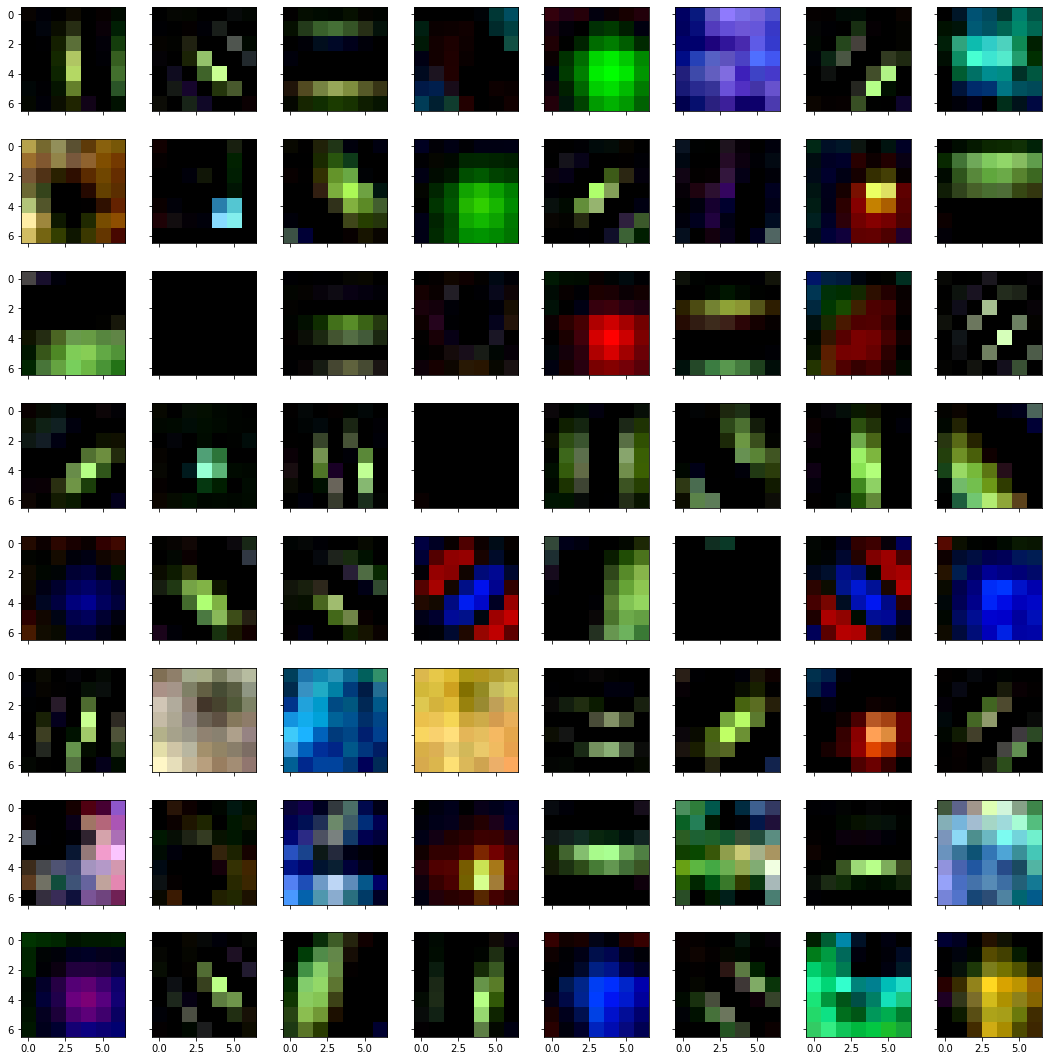

In [8]:
def visualize_first_conv(model):
    first_conv = model.conv1
    first_conv_w = first_conv.weight.data

    C_out = first_conv_w.shape[0]
    (nrows,ncols) = get_nrows_ncols(C_out)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15), sharex=True, sharey=True)
    fig.tight_layout()

    # For each filter in the first conv layer, print its weight values
    for c in range(C_out):
        rescaled = rescale(first_conv_w[c])
        axs.flat[c].imshow(rescaled.permute(2,1,0)) 
    plt.show()
visualize_first_conv(resnet)

### Load a subset of the COCO dataset 

We will use ``CocoSubset_trains_kitchens`` and ``CocoSubset_zebras`` later

``get_activation`` is a utility function that will allow us to store the activation values of a given layer for each input we will give. (Copied from the [pytorch forum](https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6))

In [15]:
# Note we don't normalize here to make the visualization easier 
# and because we don't really care about the performance
preprocessor = transforms.Compose([
    transforms.Resize(256),     
    transforms.CenterCrop(224), 
    transforms.ToTensor(),
])  

def load_CocoSubset(data_path = './data/CocoSubset/', transform = preprocessor):
    imgs_t = []                       # Where input tensors will be stored  
    list_files = listdir(data_path)   # Find all filenames in the 'imgs/' folder
    n_imgs = len(list_files)
    
    for f in list_files:
        img = Image.open(data_path + f)
        img = img.convert('RGB')
        img_t = transform(img) 
        imgs_t.append(torch.unsqueeze(img_t, 0))
    print('Size of the dataset: ', n_imgs)
    return torch.cat(imgs_t, dim=0)

def load_CocoSubset_trains_kitchens(data_path_root= './data/', transform = preprocessor):
    imgs_kitchens = load_CocoSubset(data_path = data_path_root + 'CocoSubset_Kitchens/', transform = transform)
    imgs_trains = load_CocoSubset(data_path = data_path_root + 'CocoSubset_Trains/', transform = transform)
    return imgs_kitchens, imgs_trains

def load_CocoSubset_zebras(data_path_root= './data/', transform = preprocessor):
    imgs_horses = load_CocoSubset(data_path = data_path_root + 'CocoSubset_Zebras/', transform = transform)
    return imgs_horses

activation = {}
def get_activation(name):
    """
    To store activation values
    """
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

imgs = load_CocoSubset()

Size of the dataset:  800


## 3. Last layer: Nearest neighbors

*(Starting at 12:30 of the video lecture)*

### Pixel wise distance

A naive method for comparing 2 images could be to compute their pixelwise distance. That is to say, if 2 images ``img1 , img2`` are represented by 2 arrays of dimension ``(C, H, W)``, their distance could be computed as: $$\sqrt{\sum_{h} \sum_{w} \sum_{c} (img1[c, h, w] - img2[c, h, w])^2}$$

Which can be interpreted as considering that an image is one very long vector of dimension ``C*H*W``

--------------------
## TODO

1. Write a function ``compute_mean_pixel_value_image(img)`` that takes as input ``img``, a tensor of dimension ``(C, H, W)`` and that:   
  1.1 Compute the mean value pixel value ``mean_pixel`` of ``img`` (so the mean is a tensor of 3 elements)  
  2.1 Create and return a tensor of the same shape of ``img`` whose pixels values are all equal to ``mean_pixel``  

**Hint** You can use [torch.mean](https://pytorch.org/docs/stable/generated/torch.mean.html#torch.mean) and [torch.ones_like](https://pytorch.org/docs/stable/generated/torch.ones_like.html?highlight=ones_like#torch.ones_like)

1. Write a function ``compute_pixel_wise_distance(img1, img2)`` that takes as input ``img1 , img2``, 2 tensors of dimension ``(C, H, W)`` and that returns the pixelwise distance between  ``img1`` and ``img2``

In [10]:
def compute_mean_pixel_value_image(img):
    # TODO!
    out = torch.ones_like(torch.zeros(img.shape[0], img.shape[1], img.shape[2]))
    for channel in range(img.shape[0]):
        out[channel] = torch.mul(out[channel], torch.mean(img[channel]))
    return out

def compute_pixel_wise_distance(img1, img2):
    # TODO!
    ...
    acc = 0
    for c in range(img1.shape[0]):
        for h in range(img1.shape[1]):
            for w in range(img1.shape[2]):
                acc += (img1[c][h][w] - img2[c][h][w])**2
    return np.sqrt(acc)
                

### 3.1 Comparing images pixel wise

In the cell below we do the following:

1. Compute pairwise distances in the image space (input space) of all the images in our dataset
2. Sort these pairwise distances so that for each image in the dataset, we find the other images that are the closest to it in the image space
3. For a each image in a given set of reference images, plot the images that are the closest to it.

--------------------
## TODO

Run the cell below and answer the following questions

1. Are there common objects in the images that are considered 'close' to the reference image? 
Scenes of animals seem to occur close, this may however be because they are usually placed on grass fields. The same applies for bathroom scenes.
1. If there are common objects, are they always in the same place?
No
1. Is the background similar (in terms of pixel values)?
Yes
1. Would you say that the images are similar in terms of content / context ?
1. If we take an image and the exact same one but horizontally flipped , would they be close to each other pixel wise?
Only if the image is covered evenly by a color. 
1. Are there any reference images whose their corresponding mean pixel value image is actually closer than the closest images found in the dataset?
1. Would you say that pixel-wise distance is a good measure of how similar the content of 2 images can be? 

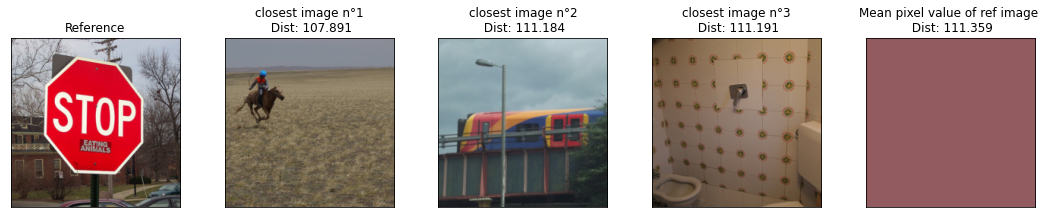

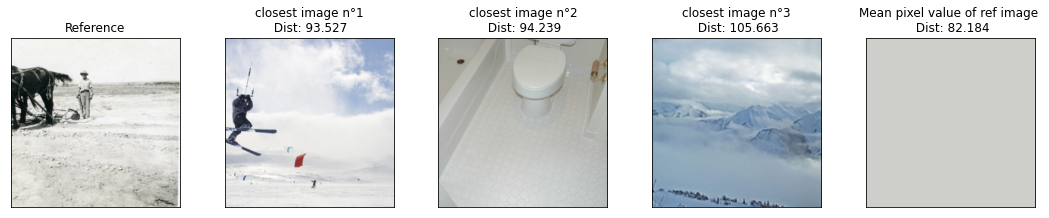

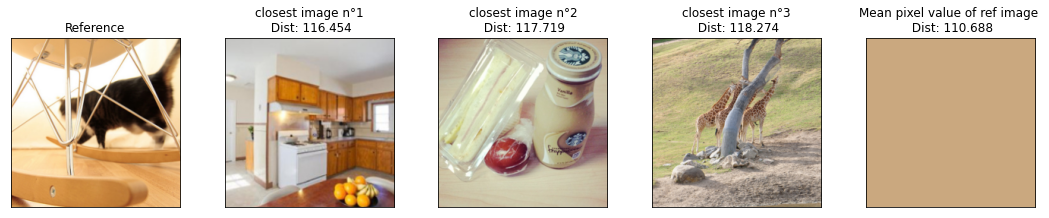

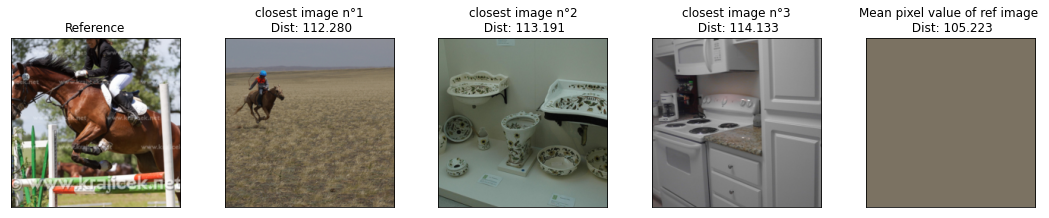

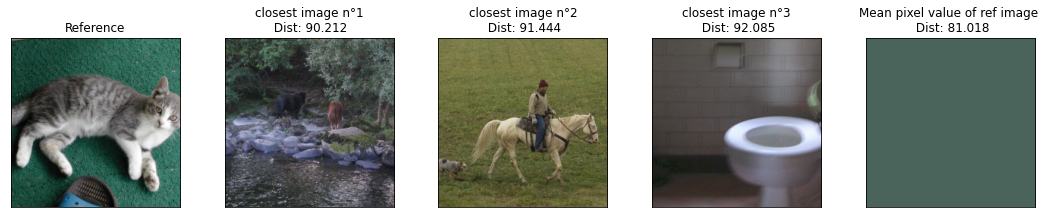

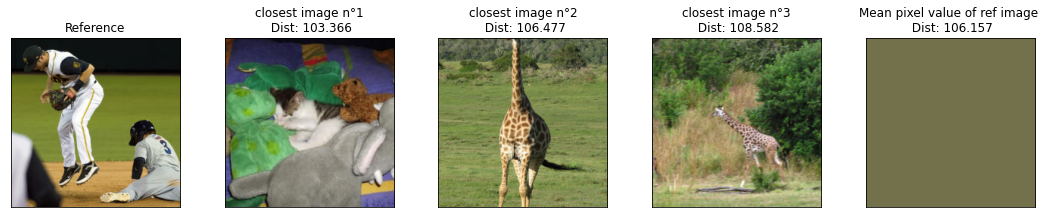

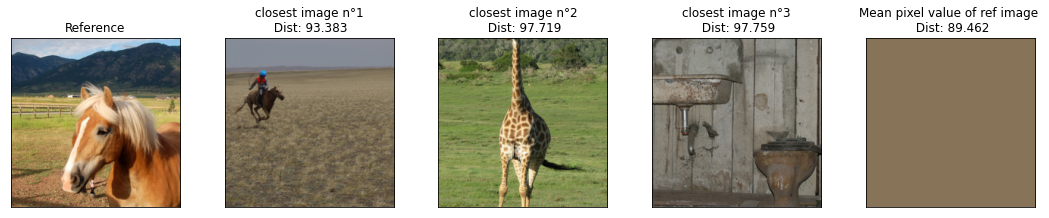

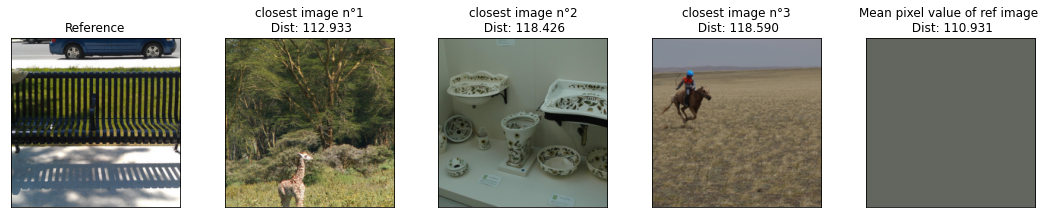

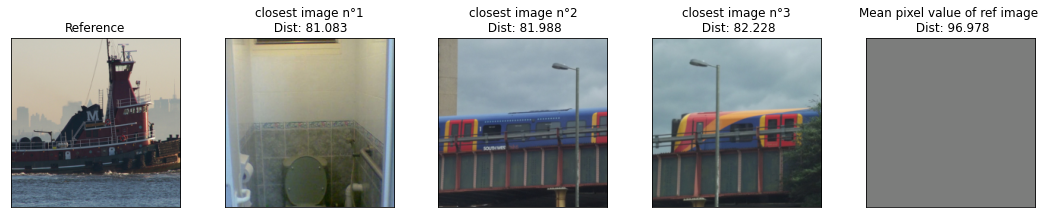

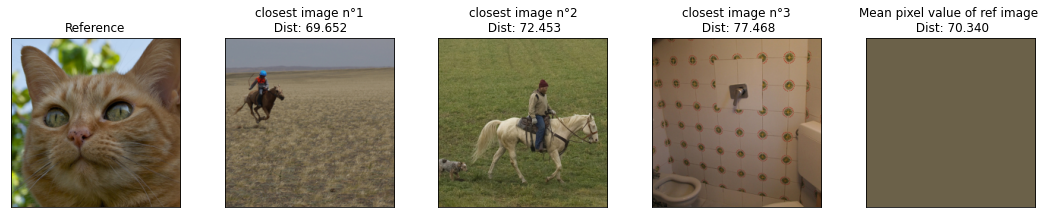

In [11]:
def plot_closest_images(imgs, distance, argsort_distance, n_imgs = 10, n_closest = 4, seed=42, show_mean=True):
    """
    Given pairwise distances and their argsort, for each randomly selected reference image, 
    plot the images that are the closest to it
    """
    # Get a random subset of the indices of imgs
    idx = np.arange(len(imgs))
    np.random.seed(seed) 
    np.random.shuffle(idx)
    idx = idx[:n_imgs]

    ncols = n_closest
    # Add an extra image composed of the mean pixel value
    if show_mean:
        ncols += 1


    for i in idx:
        
        fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(15,4))
        fig.tight_layout()
        for n in range(n_closest):
            if n == 0:
                ax_title = "Reference"
            else:
                ax_title = "closest image n°" + str(n)  +"\n Dist: %.3f"%distance[i, argsort_distance[i,n]]

            # For each reference image, plots the images that are the closest to it in the image space
            axs.flat[n].imshow(imgs[argsort_distance[i,n]].permute(1,2,0)) 
            axs.flat[n].axes.xaxis.set_visible(False)
            axs.flat[n].axes.yaxis.set_visible(False)
            axs.flat[n].axes.set_title(ax_title)  

        # UNCOMMENT THIS PART ONLY IF YOU HAVE SUCCEEDED IN WRITING THE FUNCTIONS IN THE PREVIOUS CELL
        # **************************************************************************************
        # Plot the mean pixel value image of the reference image
        if show_mean:
            mean_img = compute_mean_pixel_value_image(imgs[argsort_distance[i,0]])
            axs.flat[-1].imshow(mean_img.permute(1,2,0)) 
            axs.flat[-1].axes.xaxis.set_visible(False)
            axs.flat[-1].axes.yaxis.set_visible(False)
            dist = compute_pixel_wise_distance(mean_img, imgs[argsort_distance[i,0]])
            ax_title = "Mean pixel value of ref image \n Dist: %.3f"%dist
            axs.flat[-1].axes.set_title(ax_title)  
        # **************************************************************************************

# Both following cells share the same seed so that if they are run successively they share the same reference images
# And you can re-run successively the 2 following cells to start with new reference images
seed = randint(0,221) 

# Compute pairwise distance in the image space (input space) of all the images in our dataset
img_space_distance = pairwise_distances(imgs.flatten(1))
# Sort these pairwise distances so that for each image in the dataset, we find the other images that are the closest to it in the image space
argsort_img_space_distances = np.argsort(img_space_distance, axis=1)
# Plot all that :) 
plot_closest_images(imgs, img_space_distance, argsort_img_space_distances, seed=seed)

### 3.2 Comparing images in the feature space of the last layer of resnet

In the cell below we will use the same reference images as in the cell above, but this time we will compare them in the feature space of the last layer of the model. To do so we will give the images as input to the model and store the activations values of the last layer corresponding to each input image into a tensor ``activations_last_layer``

--------------------
## TODO

In the cell below do the following (you can find some inspiration in the cell above):

1. Compute pairwise distances in the feature space of all the images in our dataset. That is to say, compute pairwise distances between all the activations values (stored in ``activations_last_layer``) of the last layer. 
2. Sort these pairwise distances so that for each image in the dataset, we find the other images that are the closest to it in the feature space
3. For a each image in a given set of reference images, plot the images that are the closest to it. (use ``plot_closest_images`` from the cell above)


Run the cell below and answer the following questions

1. Are there common objects in the images that are considered 'close' to the reference image? 
Animals perform very strongly. This time however, related images are usually images of the same object.
1. If there are common objects, are they always in the same place?
No, the objects appear in different places.
1. Is the background similar (in terms of pixel values)?
No, backgrounds differ wildly.
1. Would you say that the images are similar in terms of content / context ?
Yes. All baseball players are featured in striking position
1. If we take an image and the exact same one but horizontally flipped , would they be close to each other in the feature space?
1. Are there any reference images whose their corresponding mean pixel value image is actually closer than the closest images found in the dataset?
1. Would you say that the model is able to associate images whose contents are similar? (Again this model has not been trained with this dataset nor with the type of objects in these images)
Yes.

torch.Size([800, 2048])


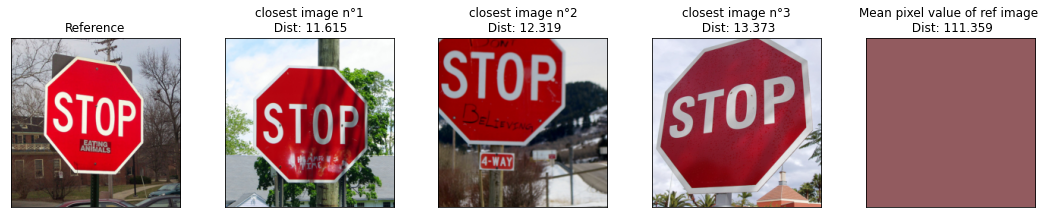

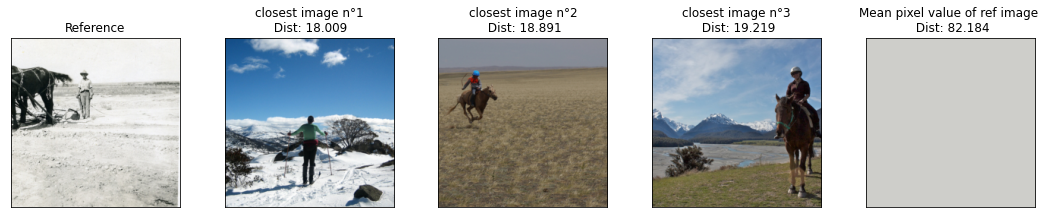

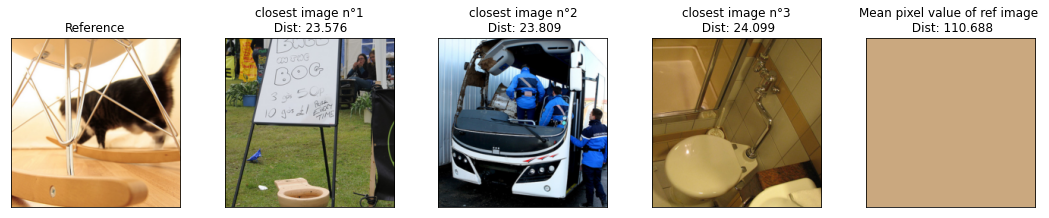

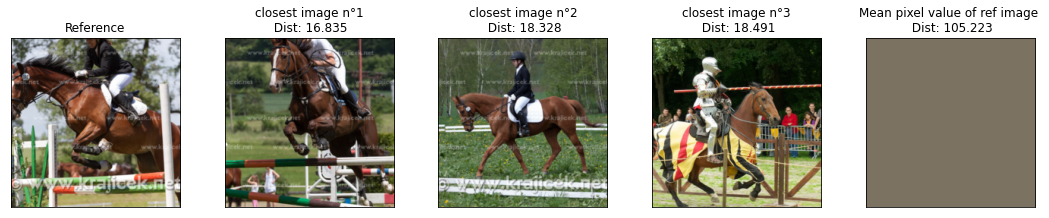

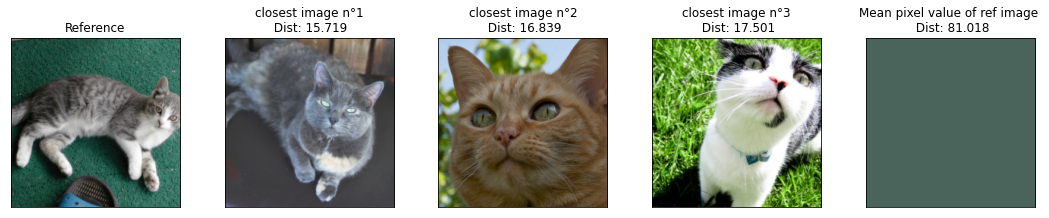

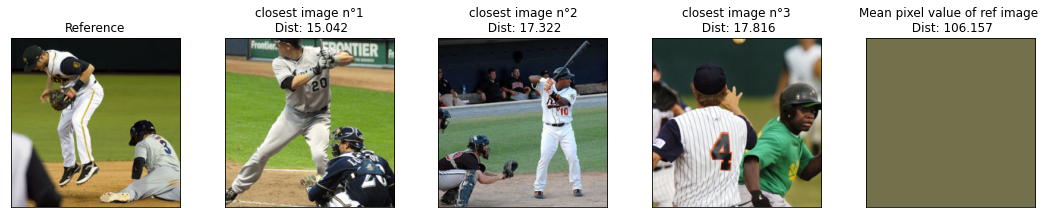

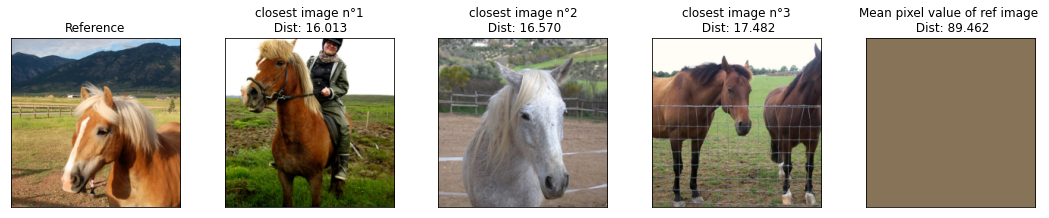

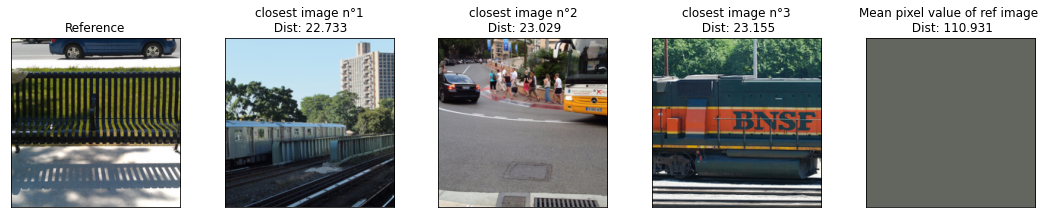

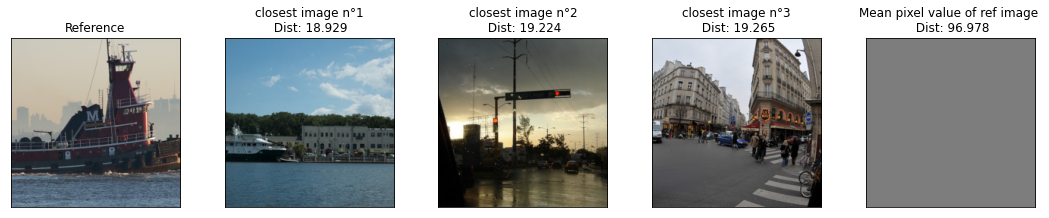

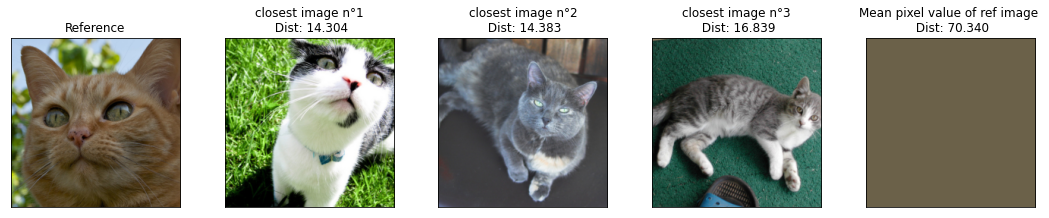

In [13]:
def get_feature_space_values(model, imgs, layer_names=['avgpool'], i_children=[None], sublayer_names=[None]):
    """
    Returns a list of activation values for each input image and each layer given as parameters
    """
    # Where we will store all the layers to be registered
    layers_to_register = []
    
    # We tell our model to keep track of the output values of the given layers
    for l, (layer_name, i_child, sublayer_name) in enumerate(zip(layer_names, i_children, sublayer_names)):
        layers_to_register.append(get_layer(model, layer_name=layer_name, i_child=i_child, sublayer_name=sublayer_name))
        layers_to_register[-1].register_forward_hook(get_activation(layers_to_register[-1]))

    # Where we will store the activations of each layer for each input
    activations = [[] for _ in range(len(layers_to_register))]
    
    resnet.eval()
    with torch.no_grad():

        # Forward pass
        # We don't have that many images, so we can pass the all at once
        resnet(imgs)

    # Get the output values of the registered layers corresponding to each input images 
    for l, layer_to_register in enumerate(layers_to_register):
        activations[l] = activation[layer_to_register].squeeze()

    return activations


# This if condition is there because it's quite slow to get the activations values but I wanted to keep this line in this cell for clarity purpose
if 'activations_last_layer' not in globals():
    activations_last_layer = get_feature_space_values(resnet, imgs, layer_names=['avgpool'])[0]

# (Batch-size, last layer shape)
print(activations_last_layer.shape)

# Compute pairwise distance in the feature space (last layer)
# TODO!
activations_pairwise_distance = pairwise_distances(activations_last_layer.flatten(1))
# For each reference image, find the images that are the closest to it in the feature space
# TODO!
argsort_distances = np.argsort(activations_pairwise_distance, axis=1)
# Plot all that :) 
# TODO!
plot_closest_images(imgs, activations_pairwise_distance, argsort_distances, seed=seed)

## 4. Last layer: Dimensionality reduction and distinguishing between kitchens and trains

*(Starting at 17:20 of the video lecture)*

Visualizing tensors that do not represent images and that are arrays or vectors of high dimension is really hard. Most of the time we are compelled to go back to $\mathrm{R}^2$ or $\mathrm{R}^3$ by using a dimensionality reduction method. However we might loose crucial information when projecting a high dimensional space onto $\mathrm{R}^2$ or $\mathrm{R}^3$ and most of the time it is impossible to extract any meaningful information from raw high-dimensional data directly projected  onto a 2D space. However in this section we will see that we can project the last layer activations onto $\mathrm{R}^2$ and that in this projection we can see that the model has managed to distinguish between 2 classes of images.

Here we will play with only 2 types of images: kitchens and trains. Both labels were NOT among the labels Resnet has been trained with.

--------------------
## TODO

In the ``Projection from the input space`` section:

1. Instantiate a PCA model that would keep only the first 2 principal components (see [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA))
1. Fit the PCA model with the tensor containing both kitchens and trains images (see [PCA.fit](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA.fit)) **Note** you must first see each image as a vector of dimension ``C*H*W`` see [torch.flatten](https://pytorch.org/docs/stable/tensors.html?highlight=flatten#torch.Tensor.flatten) and its ``start dim`` parameter)
1. Finally, project  ``imgs_kitchens`` and then ``imgs_trains`` onto $\mathrm{R}^2$ using your PCA model (see [PCA.transform](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA.transform)). Store the output in ``imgs_kitchens_transformed`` and ``imgs_trains_transformed``

In the ``Projection from the feature space`` section:

1. Instantiate another PCA model that would keep only the first 2 principal components 
1. Fit this second PCA model with the tensor containing both the kitchens and the trains activations values in the last layer.
1. Finally, project  ``act_kitchens`` and then ``act_trains`` onto $\mathrm{R}^2$ using your PCA model. Store the output in ``act_kitchens_transformed`` and ``act_trains_transformed``

Visualization: 

1. Could you distinguish between kitchen and trains in the 2D projection of the input space?
Definitely not
1. Could you distinguish between kitchen and trains in the 2D projection of the feature space?
Yes
1. The model has not been trained to distinguish between trains and kitchen but do you think that the model is after all able to distinguish between trains and kitchens?
Yes

Size of the dataset:  34
Size of the dataset:  33


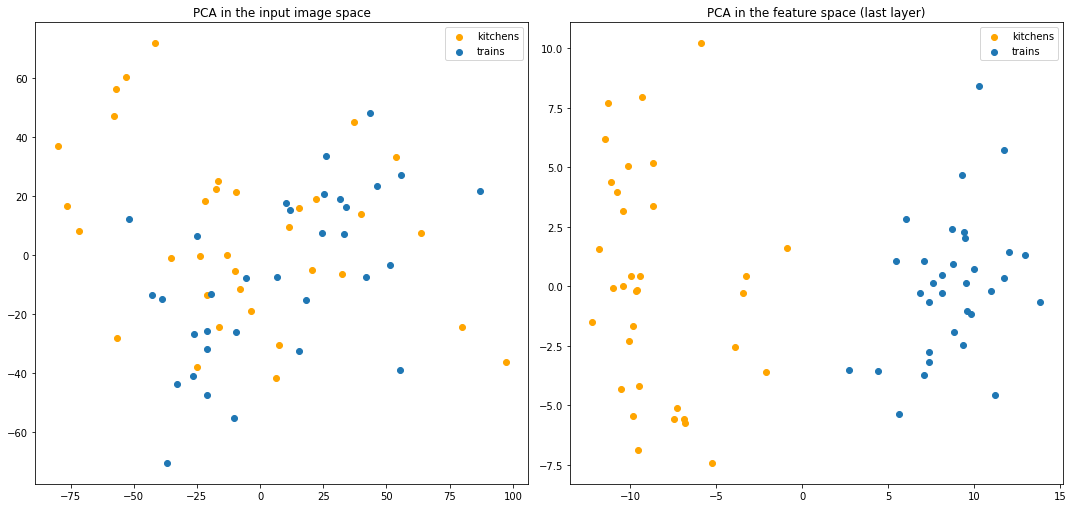

In [25]:
def visualize_pca(imgs_kitchens_transformed, imgs_trains_transformed, act_kitchens_transformed, act_trains_transformed):
    """
    Plot the PCA projections from the input space and from the feature space onto R^2
    """
    fig, axs = plt.subplots(ncols = 2, figsize=(15,7))
    fig.tight_layout()
    axs[0].scatter(imgs_kitchens_transformed[:,0], imgs_kitchens_transformed[:,1], c='orange', label='kitchens')
    axs[0].scatter(imgs_trains_transformed[:,0], imgs_trains_transformed[:,1], label='trains')
    axs[0].axes.set_title('PCA in the input image space')  
    axs[0].legend()

    axs[1].scatter(act_kitchens_transformed[:,0], act_kitchens_transformed[:,1], c='orange', label='kitchens')
    axs[1].scatter(act_trains_transformed[:,0], act_trains_transformed[:,1], label='trains')
    axs[1].axes.set_title('PCA in the feature space (last layer)')  
    axs[1].legend()

# -------------------------------------------------------
# Projection from the input space
# -------------------------------------------------------

# Load the kitchens and trains images 
imgs_kitchens, imgs_trains = load_CocoSubset_trains_kitchens()
# Create a big tensor contaning both kitchens and trains
imgs_2 = torch.cat([imgs_kitchens, imgs_trains])

# Fit a PCA model that keeps only the first 2 principal component
# TODO!
model_PCA = PCA(n_components=2)
imgs_2 = torch.flatten(imgs_2, 1)
model_PCA.fit(imgs_2)

# Project images from the input space onto R2 using the PCA model  
# TODO!
imgs_kitchens_transformed = model_PCA.transform(torch.flatten(imgs_kitchens, 1))
imgs_trains_transformed = model_PCA.transform(torch.flatten(imgs_trains, 1))

# -------------------------------------------------------
# Projection from the feature space
# -------------------------------------------------------

# Get the activations values for both kitchens and trains
act_kitchens = get_feature_space_values(resnet, imgs=imgs_kitchens, layer_names=['avgpool'])[0] 
# [0] Because the function returns a list of activations for each layer
act_trains = get_feature_space_values(resnet, imgs=imgs_trains, layer_names=['avgpool'])[0]
# Create a big tensor contaning both kitchens and trains activations values 
act_2 = torch.cat([act_kitchens, act_trains])

# Fit a PCA model that keeps only the first 2 principal component
# TODO!
model_2_PCA = PCA(n_components=2)
model_2_PCA.fit(act_2)

# Project activations from the feature space onto R2 using the PCA model  
# TODO!
act_kitchens_transformed = model_2_PCA.transform(act_kitchens)
act_trains_transformed = model_2_PCA.transform(act_trains)


# -------------------------------------------------------
# Visualization
# -------------------------------------------------------

visualize_pca(imgs_kitchens_transformed, imgs_trains_transformed, act_kitchens_transformed, act_trains_transformed)


## 5. Hidden convolutional layers: Maximum activations

*(Starting at 22:00 of the video lecture)*

In the cell below (which might take some time to run) we get the activation values for all input images (back to the entire COCO_Subset) in 3 different hidden convolutional layers: the first one we keep track of is at the very beginning of the model, the second one in the middle of the model and the last one near the end of the model.

In [32]:
# ----------------------------------
# Getting the activation values
# ----------------------------------
layer_names = ['layer1', 'layer2', 'layer3']
i_children = [0, 1, 22]
sublayer_names = ['conv2']*3

# Again, just in case you re-run this cell accidentally
if 'activations_convs' not in globals():
    activations_convs = get_feature_space_values(resnet, imgs, layer_names=layer_names, i_children=i_children, sublayer_names=sublayer_names)

for activations_conv in activations_convs:
    print(activations_conv.shape)



torch.Size([800, 256, 56, 56])
torch.Size([800, 512, 28, 28])
torch.Size([800, 1024, 14, 14])


In [33]:
def plot_max_act(imgs, activations, argsort_act, n_imgs = 9):
    """
    Plot images alongside the activations of the filters
    """
    fig, axs = plt.subplots(nrows = n_imgs , ncols = 2*len(activations), figsize=(15,20))
    fig.tight_layout()
    for i in range(n_imgs):
        for c, (act_c, argsort_act_c) in enumerate(zip(activations, argsort_act)):

            # Plot the original image
            axs[i, 2*c].imshow(imgs[ argsort_act_c[i][0] ].permute(1,2,0)) 
            axs[i, 2*c].axes.xaxis.set_visible(False)
            axs[i, 2*c].axes.yaxis.set_visible(False)
            axs[i, 2*c].axes.set_title("Original image")

            # Plot the activations of the filter that was the most activated in average by this image
            axs[i, 1+2*c].imshow(act_c[ argsort_act_c[i][0], argsort_act_c[i][1] ]) 
            axs[i, 1+2*c].axes.xaxis.set_visible(False)
            title = "Filter #%d \nUnits activations" %argsort_act_c[i][1]
            if i == 0:
                title = "Layer #%d\n\n" %(c+1) + title
            axs[i, 1+2*c].axes.yaxis.set_visible(False)
            axs[i, 1+2*c].axes.set_title(title)
    plt.show()

In the cell below we try to find the images and filters that resulted in the max activations. We then plots for each layer the input images that resulted in a high activation alongside their associated filter activations.

--------------------
## TODO

1. Do the 3 convolutional layers inspected seem to look for the same kind of thing in the image?
Filter 1 and 2 seem to look for the samt thing. With filter three it's hard to tell as the images have become so compressed. 
1. Do you think that the depth of the convolutional layer impacts its behaviour? 
No
1. In the layer #1, what seems to activate the filter #57 
1. In the layer #3, what seems to activate the filter #150? And the filter #139?
These filters do not appear in my output..?

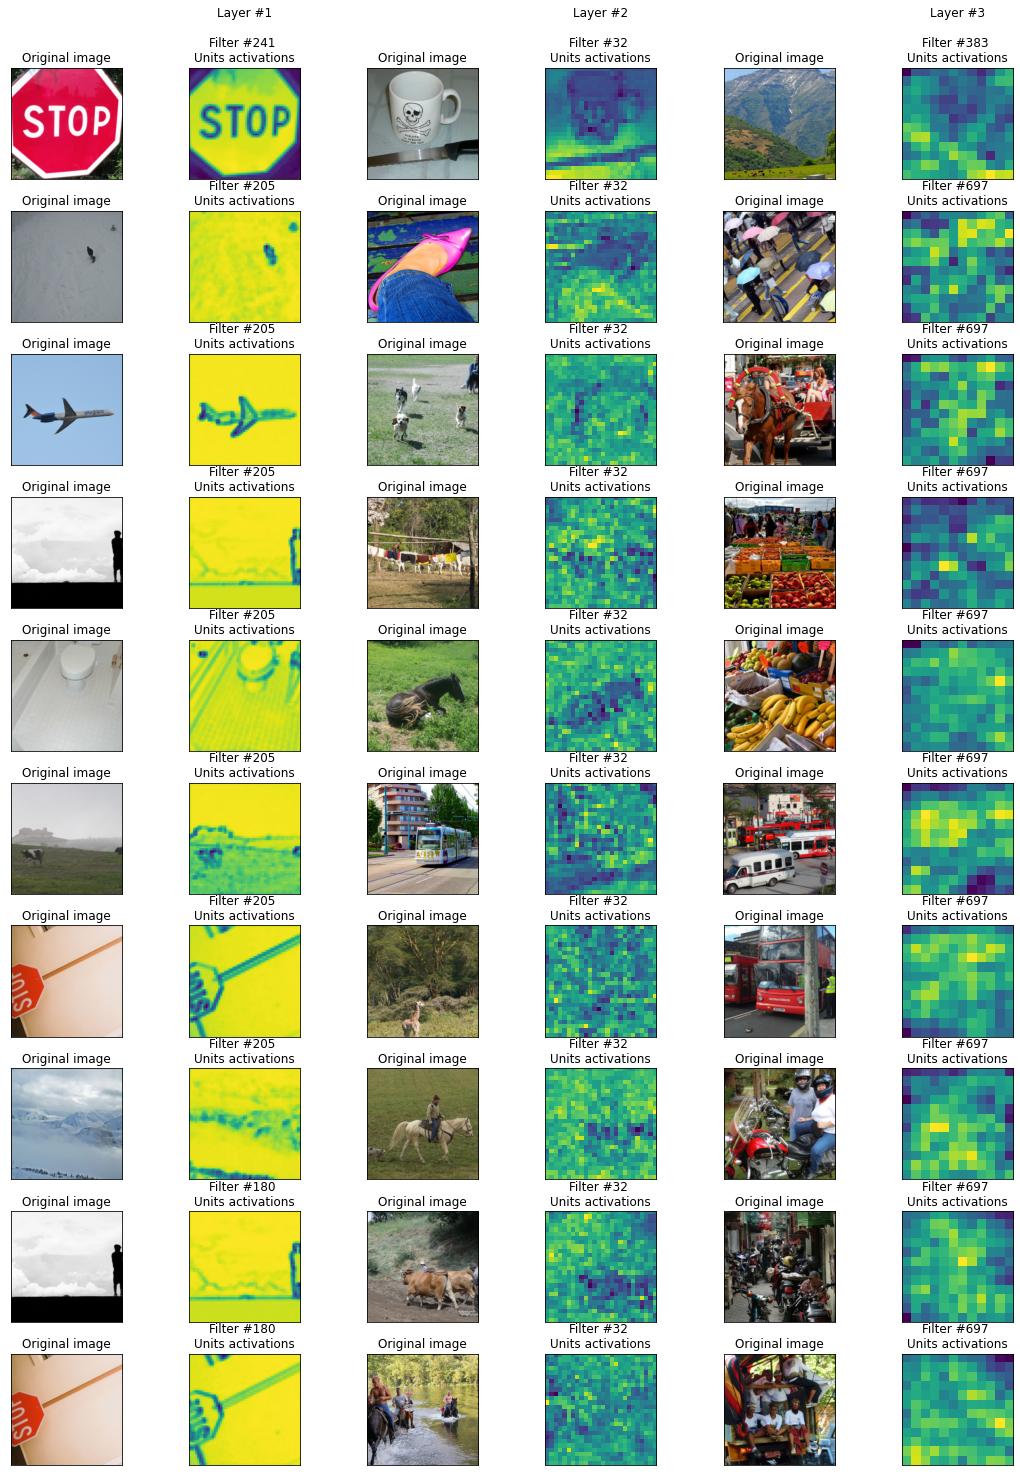

In [35]:
# ----------------------------------
# Visualzing filter activations 
# ----------------------------------

n_conv = len(activations_convs)
argsort_act_convs = [[] for _ in range(n_conv)]
act_convs = [[] for _ in range(n_conv)]

for i in range(n_conv):
    # We don't take the borders element because they are a bit biased
    act_convs[i] = rescale(activations_convs[i][:,:,1:-1,1:-1])

    # For each input image and each filter, find its mean activation
    mean_activation = torch.mean(act_convs[i], dim=(2,3))

    # Sort in descending order so that we can find the images and filters that resulted in the max mean activation
    # argsort_act_convs[i] = torch.argsort(mean_activation, descending=True)
    argsort_act_convs[i] = np.dstack(np.unravel_index(
            np.flip(np.argsort(np.array(mean_activation).ravel())), (mean_activation.shape[0], mean_activation.shape[1])
        )).squeeze()

# Plot images alongside the activations of the filters that maximized the activation
plot_max_act(imgs, act_convs, argsort_act_convs, n_imgs = 10)

## 6. Occlusion experiments

*(Starting at 29:00 of the video lecture)*

--------------------
## TODO

1. Describe as thoroughly as possible the experiment implemented in the following cells.   
  1.1 What is the objective pf the experiment? 
  The point is to visualize which patterns are used as activations when identifying the zebras.
  1.2 What is ``occlusion`` doing?  
  Occlusion generates an empty heatmap image, makes the prediction on its corresponding input image and maps the prediction onto the heatmap.
  1.3 Do the model has to be trained to classify the type of image used for the experiment to work properly? Why? 
  Yes.  
1. Which parts of the zebra seem to be the most essential to the model?
Ears, eyes and foreheads


In [29]:
def occlusion(model, image, label, occ_size = 50, occ_stride = 50, occ_pixel = 0., device=torch.device('cpu')):
    model.eval()
  
    # get the width and height of the image
    H_in, W_in = image.shape[-2], image.shape[-1]
    pad = occ_size - occ_stride
  
    # setting the output image width and height
    H_out = (H_in + 2*pad -occ_size) // occ_stride + 1
    W_out = (W_in + 2*pad - occ_size) // occ_stride + 1
  
    # Instantiante heatmap
    heatmap = torch.zeros((H_out, W_out))

    # Apply some padding so that the heatmap locations seem more accurate
    input_image = F.pad(image.clone().detach(), (pad, pad)).to(device=device)
    
    for h in range(H_out):

        images_w = [input_image.clone() for _ in range(W_out)]

        for w in range(W_out):            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(H_in, h_start + occ_size)
            w_end = min(W_in, w_start + occ_size)

            # replacing all the pixel in the image with occ_pixel (default black) in the specified location
            images_w[w][:,:, h_start:h_end, w_start:w_end] = occ_pixel
        
        # Create a batch containing all the occluded images at a given height
        images_w = torch.cat(images_w).to(device=device)
            
        # Make predictions and get the probability of the given label
        with torch.no_grad():
            outputs = model(images_w)
            outputs = nn.functional.softmax(outputs, dim=1)
        _, index = torch.max(outputs, 1)
        probs = outputs[:,label]
        
        #setting the heatmap location to probability value
        heatmap[h, :] = probs

    return heatmap

In [30]:
# load images containing exclusively zebras  
imgs_zebras = load_CocoSubset_zebras()
print(imgs_zebras.shape)

# Using GPU if possible as this experience is a bit slow...
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"On device {device}.")
resnet_gpu = models.resnet101(pretrained=True).to(device=device)

Size of the dataset:  7
torch.Size([7, 3, 224, 224])
On device cpu.


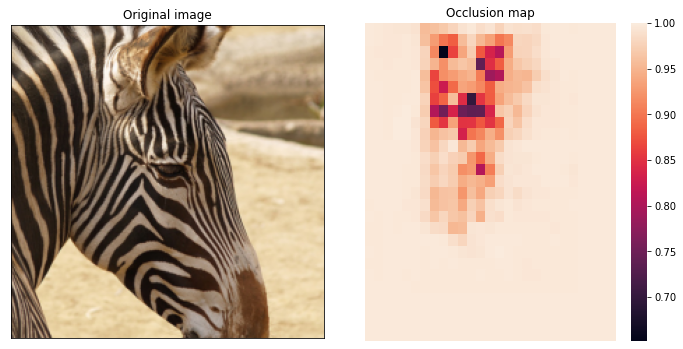

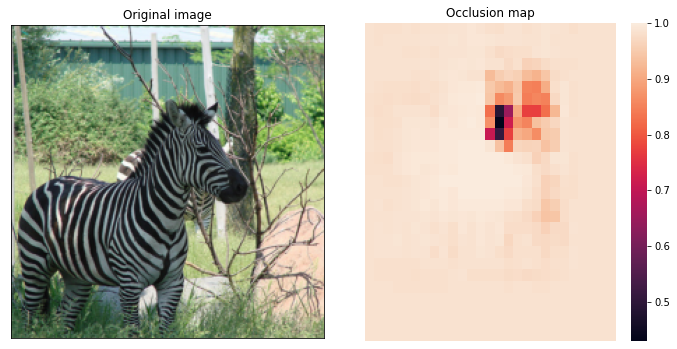

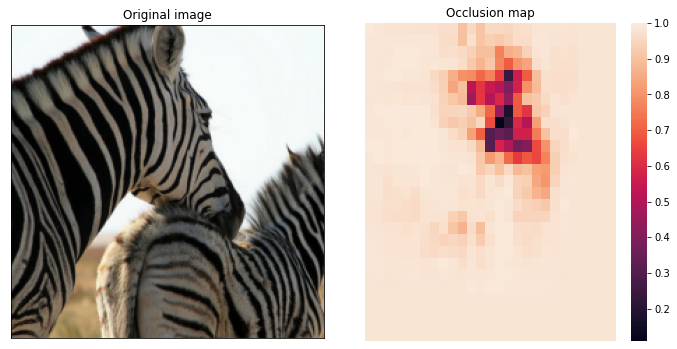

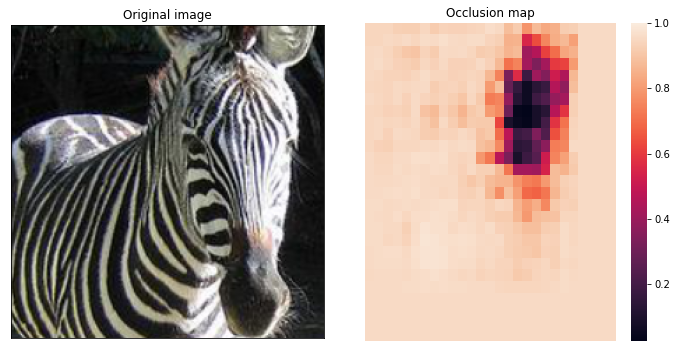

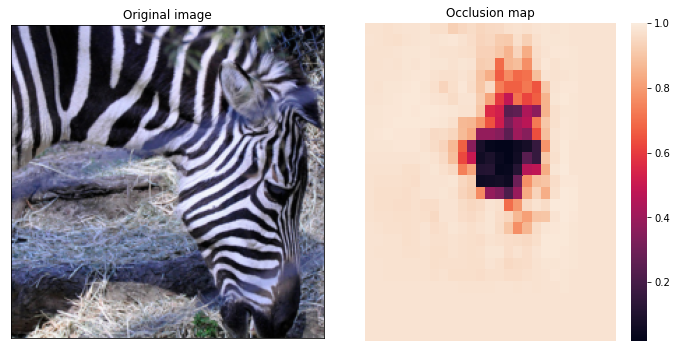

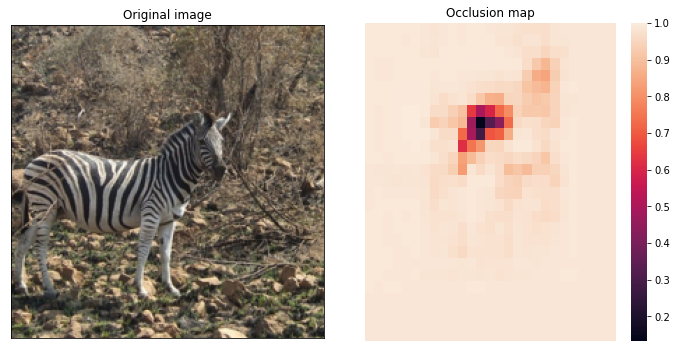

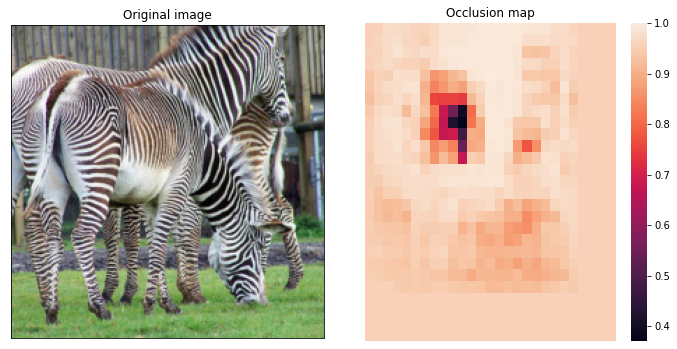

In [31]:
label_zebra = 340 # Label of zebra in the ImageNet dataset

for img in imgs_zebras:
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    fig.tight_layout()

    # Plot original image
    axs.flat[0].imshow(img.permute(1,2,0)) 
    axs.flat[0].axes.xaxis.set_visible(False)
    axs.flat[0].axes.yaxis.set_visible(False)
    axs.flat[0].set_title("Original image")

    # Compute occlusion map
    # This might be slow. You can set a higher stride if you need. But the experience will be much less interesting if the strides goes higher
    # Try first with fewer images if it is really slow
    heatmap = occlusion(model=resnet_gpu, image=img.unsqueeze(dim=0), label=label_zebra, occ_size=60, occ_stride=10, device=device)

    # Plot the occlusion map
    sns.heatmap(heatmap, cbar=True, xticklabels=False, yticklabels=False, ax=axs.flat[1], vmax=1)
    axs.flat[1].set_title("Occlusion map")
    plt.show()